# Practical Lab 2 — Multivariate Linear Regression, Non‑Parametric Models, and Cross‑Validation (Diabetes)

**Dataset:** Scikit‑Learn Diabetes dataset (disease progression one year after baseline)  
**Date:** 2026-02-26

**Name:** Param Avinashkumar Rasaniya  
**Student ID:** 9086095

## Notebook Purpose (Good Notebook Structure)
This notebook is written as a clear ML report:
- Problem framing (why we model, what the target means, and how to read metrics)
- EDA (stats + visuals + short insights)
- Modeling (train/validation/test split + comparisons)
- Conclusions (where the model fails + limitations)

## Table of Contents
1. Setup
2. Get the data
3. Frame the problem
4. Exploratory Data Analysis (EDA)
5. Data cleaning (if needed)
6. Train / Validation / Test split
7. Part 2 — Univariate Polynomial Regression on BMI (degree 0 to 5)
8. Part 3 — Multivariate models (Polynomial, Decision Trees, kNN, Logistic Regression)
9. Final conclusions and limitations

## 1) Setup
We import libraries and define helper functions for:
- splitting train/validation/test
- training models
- evaluating with R², MAE, and MAPE

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Display options (readability)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

RANDOM_STATE = 42

def mape(y_true, y_pred, eps=1e-8):
    """Mean Absolute Percentage Error (MAPE) in % (eps avoids divide-by-zero)."""
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def evaluate_regression(y_true, y_pred):
    """Return required regression metrics: R2, MAE, MAPE."""
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE (%)": mape(y_true, y_pred),
    }

def summarize_split(X_train, X_val, X_test, y_train, y_val, y_test):
    return pd.DataFrame(
        {
            "Split": ["Train", "Validation", "Test"],
            "X rows": [X_train.shape[0], X_val.shape[0], X_test.shape[0]],
            "X cols": [X_train.shape[1], X_val.shape[1], X_test.shape[1]],
            "y rows": [len(y_train), len(y_val), len(y_test)],
        }
    )

## 2) Get the Data
We load the Scikit‑Learn Diabetes dataset using `as_frame=True` so we get a pandas DataFrame with column names.

In [2]:
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data.copy()
y = diabetes.target.copy()  # disease progression one year after baseline

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())
display(y.head())

X shape: (442, 10)
y shape: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

**Quick note about the features:** The diabetes dataset features are already standardized (mean ~ 0).  
That matters because polynomial terms and kNN distances can be sensitive to scale.

## 3) Frame the Problem
**Goal:** predict disease progression one year after baseline. This can act as a screening tool to flag higher‑risk patients.

### Problem type
- Target is continuous → **regression**.

### Metrics
- **R²**: variance explained (closer to 1 is better).
- **MAE**: typical absolute error in target units.
- **MAPE**: percent error (helpful for relative error; can be unstable near 0).

### Talking points (from workshops)
- Overfitting check: compare train vs validation; complex models can fit noise.
- kNN is distance‑based → feature scaling matters (good practice even if data is standardized).
- Logistic Regression is a classification method; we use it in Part 3 as a **binary screening** model (“high progression” vs “not”).

## 4) Exploratory Data Analysis (EDA)
We include:
- statistics
- scatter plots
- histograms
- correlation matrix
- short insights

In [3]:
# Summary statistics
display(X.describe().T)

print("\nTarget (y) summary:")
display(y.describe())

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.268604e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612



Target (y) summary:


count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

In [4]:
# Missing values check
missing_X = X.isna().sum().sort_values(ascending=False)
missing_y = y.isna().sum()

print("Missing values per feature (X) where > 0:")
display(missing_X[missing_X > 0])

print("Missing values in target y:", missing_y)

Missing values per feature (X) where > 0:


Series([], dtype: int64)

Missing values in target y: 0


### Histograms
We plot histograms to see the shape and spread of features and the target.

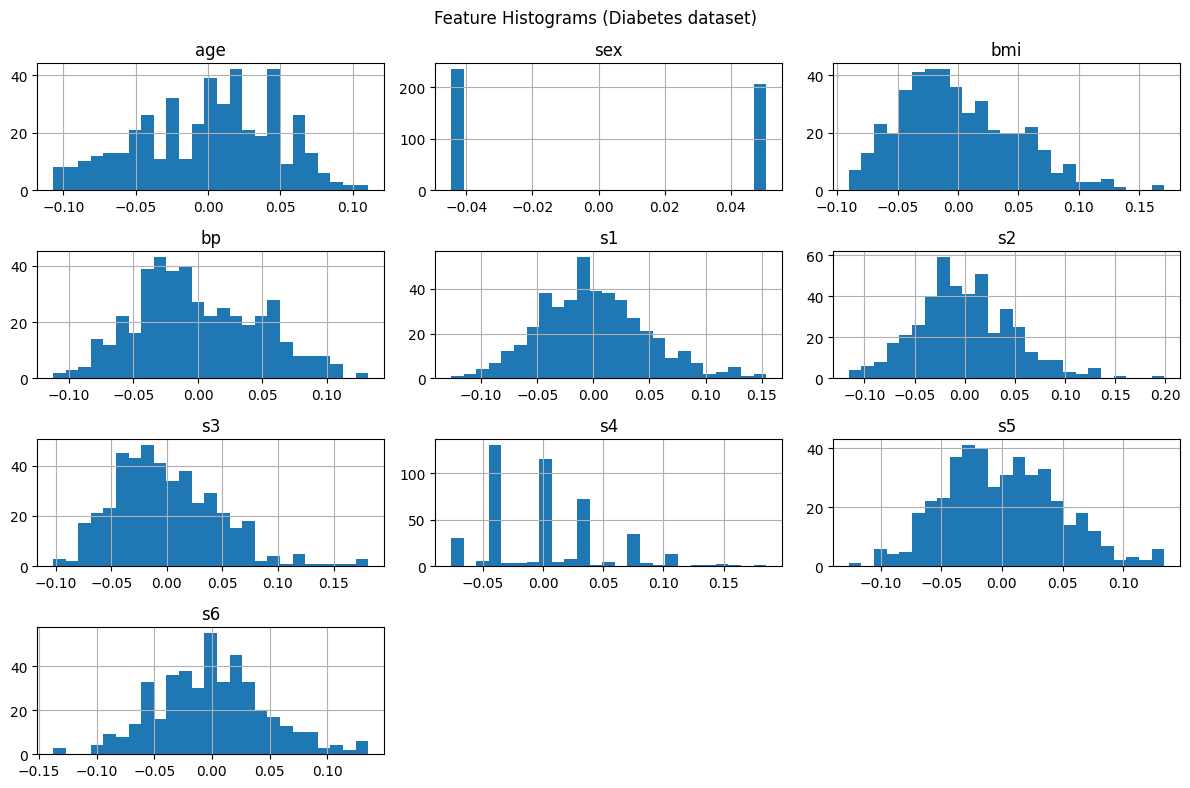

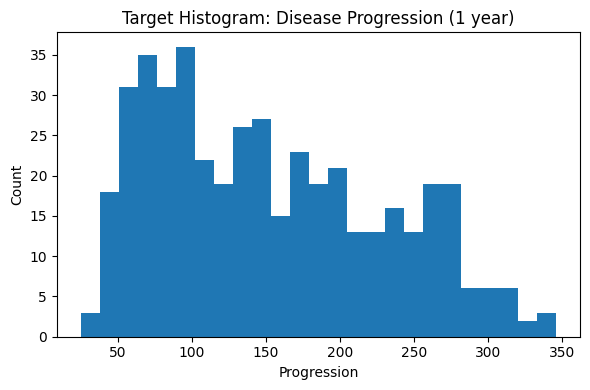

In [5]:
X.hist(figsize=(12, 8), bins=25)
plt.suptitle("Feature Histograms (Diabetes dataset)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(y, bins=25)
plt.title("Target Histogram: Disease Progression (1 year)")
plt.xlabel("Progression")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Scatter plots (feature vs target)
Scatter plots help spot linear vs non‑linear patterns and outliers.

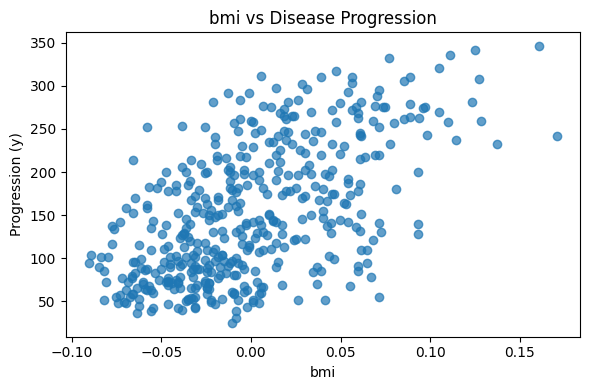

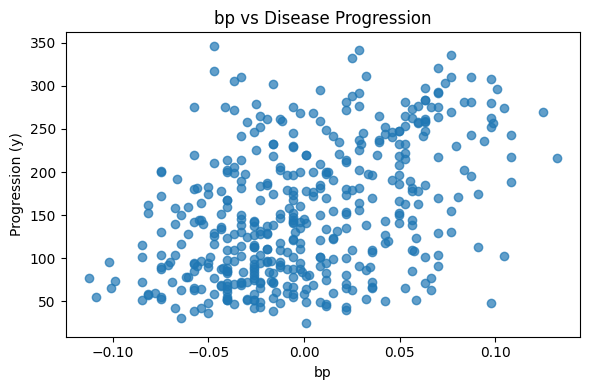

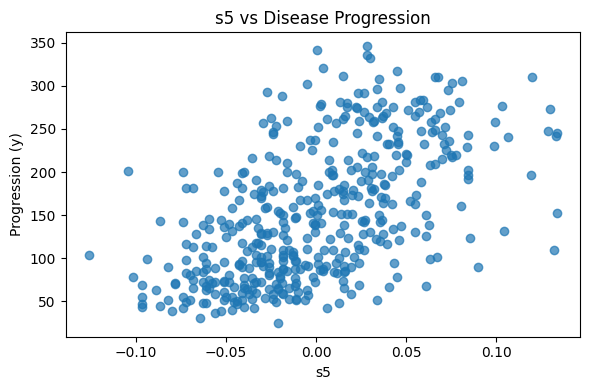

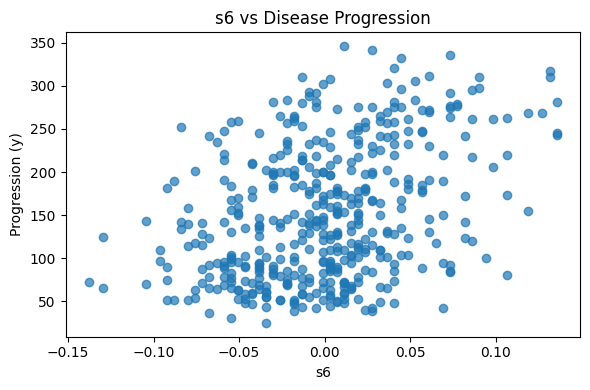

In [6]:
features_to_plot = ["bmi", "bp", "s5", "s6"]  # include BMI for Part 2
for feat in features_to_plot:
    plt.figure(figsize=(6, 4))
    plt.scatter(X[feat], y, alpha=0.7)
    plt.title(f"{feat} vs Disease Progression")
    plt.xlabel(feat)
    plt.ylabel("Progression (y)")
    plt.tight_layout()
    plt.show()

### Correlation matrix
We compute correlations to see which features are most associated with the target.

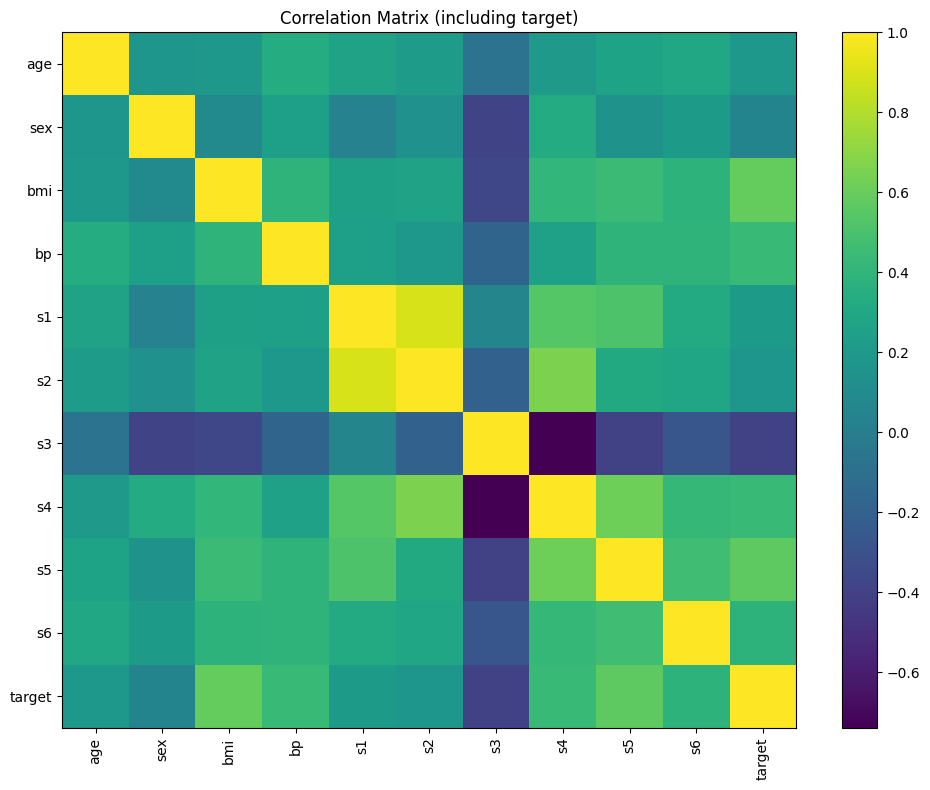

Correlation with target (sorted):


target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [7]:
df = X.copy()
df["target"] = y

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (including target)")
plt.tight_layout()
plt.show()

target_corr = corr["target"].sort_values(ascending=False)
print("Correlation with target (sorted):")
display(target_corr)

**Concise EDA insights (example):**
- BMI often shows a strong positive relationship with progression (good candidate for a baseline univariate model).
- Some features correlate with each other; multivariate polynomial models can grow large fast (overfitting risk).
- Using MAE is helpful because it is easy to interpret as “typical error size”.

## 5) Clean the Data (if needed)
We check missing values and duplicates. This dataset is curated, so usually no cleaning is required.

In [8]:
print("Any missing values in X?", X.isna().any().any())
print("Any missing values in y?", y.isna().any())
print("Duplicate rows in X:", X.duplicated().sum())

# No cleaning applied because data is already clean.

Any missing values in X? False
Any missing values in y? False
Duplicate rows in X: 0


## 6) Train / Validation / Test Split
Required split: Train 75%, Validation 10%, Test 15%. We do it in two steps.

In [9]:
# Step 1: Train+Val vs Test (15% test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE
)

# Step 2: Train vs Val inside the remaining 85%
val_size_within_trainval = 0.10 / 0.85  # makes validation 10% overall
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_within_trainval, random_state=RANDOM_STATE
)

display(summarize_split(X_train, X_val, X_test, y_train, y_val, y_test))

,Split,X rows,X cols,y rows
0,Train,330,10,330
1,Validation,45,10,45
2,Test,67,10,67


# Part 2 — Univariate Polynomial Regression on BMI (Degree 0 to 5)
We fit 6 models using only BMI: degree 0 through degree 5, then compare training vs validation performance.

## 7) Fit models and build the training/validation comparison table
Pipeline:
- PolynomialFeatures(degree=d)
- LinearRegression()

**Note about degree 0:** Degree 0 is a *constant-only* baseline (intercept only).  
In code, degree 0 is handled separately using plain `LinearRegression()` because
`PolynomialFeatures(degree=0, include_bias=False)` would create an empty feature matrix.

In [10]:
bmi_train = X_train[["bmi"]]
bmi_val = X_val[["bmi"]]
bmi_test = X_test[["bmi"]]

results = []
models = {}

for deg in range(0, 6):
    if deg == 0:
        # Degree 0 = constant model (intercept only)
        model = LinearRegression()
    else:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
            ("linreg", LinearRegression())
        ])

    model.fit(bmi_train, y_train)
    models[deg] = model

    yhat_train = model.predict(bmi_train)
    yhat_val = model.predict(bmi_val)

    train_metrics = evaluate_regression(y_train, yhat_train)
    val_metrics = evaluate_regression(y_val, yhat_val)

    results.append({
        "Degree": deg,
        "Train R2": train_metrics["R2"],
        "Val R2": val_metrics["R2"],
        "Train MAE": train_metrics["MAE"],
        "Val MAE": val_metrics["MAE"],
        "Train MAPE (%)": train_metrics["MAPE (%)"],
        "Val MAPE (%)": val_metrics["MAPE (%)"],
    })

results_df = pd.DataFrame(results).sort_values("Degree")
display(results_df)

,Degree,Train R2,Val R2,Train MAE,Val MAE,Train MAPE (%),Val MAPE (%)
0,0,0.354240,0.449292,52.278064,41.997581,48.462384,40.444999
1,1,0.354240,0.449292,52.278064,41.997581,48.462384,40.444999
2,2,0.354771,0.449158,52.267273,41.757683,48.447858,40.309938
3,3,0.355002,0.447291,52.223375,41.741042,48.356420,40.258961
4,4,0.357983,0.449064,51.944372,41.952846,47.963501,40.240642
5,5,0.358910,0.453513,51.813830,42.083400,47.831494,40.340475


## 8) Identify the best model
We choose the best model mainly based on validation performance to reduce overfitting.

In [11]:
best_row = results_df.sort_values(["Val MAE", "Val MAPE (%)", "Val R2"], ascending=[True, True, False]).iloc[0]
best_degree = int(best_row["Degree"])

print("Best degree selected:", best_degree)
display(best_row.to_frame("Best model (based on validation)").T)

Best degree selected: 3


,Degree,Train R2,Val R2,Train MAE,Val MAE,Train MAPE (%),Val MAPE (%)
Best model (based on validation),3.0,0.355002,0.447291,52.223375,41.741042,48.35642,40.258961


## 9) Run the chosen model on the test set
Test set is the final unbiased evaluation because it was not used for model selection.

In [12]:
best_model = models[best_degree]
yhat_test = best_model.predict(bmi_test)
test_metrics = evaluate_regression(y_test, yhat_test)

print("Test Metrics for best BMI polynomial model:")
display(pd.DataFrame([test_metrics]))

Test Metrics for best BMI polynomial model:


,R2,MAE,MAPE (%)
0,0.206918,54.629057,48.540799


## 10) Plot train/validation/test points + best fit curve
We plot a smooth curve of the fitted polynomial over the BMI range.

**Talking point: Why does the “polynomial” fit look like a straight line?**  
Even if the selected degree is higher (for example, degree 3), the fitted curve can still look almost linear because BMI is **standardized** and its values are relatively small (close to 0).  
When \(x\) is small, \(x^2\) and \(x^3\) become tiny, so the higher‑order terms contribute very little compared to the linear term. The model may also learn very small coefficients for those higher‑order terms based on validation performance.

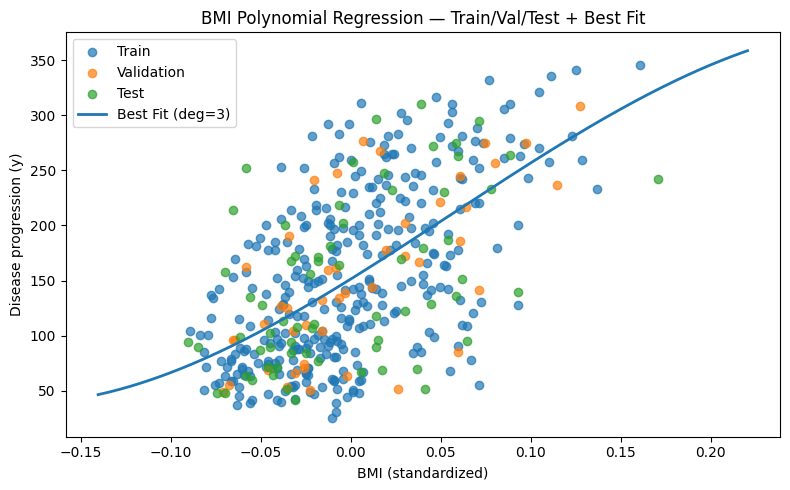

In [13]:
bmi_min, bmi_max = X["bmi"].min(), X["bmi"].max()
bmi_grid = np.linspace(bmi_min - 0.05, bmi_max + 0.05, 250)
bmi_grid_df = pd.DataFrame({"bmi": bmi_grid})

yhat_grid = best_model.predict(bmi_grid_df)

plt.figure(figsize=(8, 5))
plt.scatter(bmi_train["bmi"], y_train, alpha=0.7, label="Train")
plt.scatter(bmi_val["bmi"], y_val, alpha=0.7, label="Validation")
plt.scatter(bmi_test["bmi"], y_test, alpha=0.7, label="Test")
plt.plot(bmi_grid, yhat_grid, linewidth=2, label=f"Best Fit (deg={best_degree})")
plt.title("BMI Polynomial Regression — Train/Val/Test + Best Fit")
plt.xlabel("BMI (standardized)")
plt.ylabel("Disease progression (y)")
plt.legend()
plt.tight_layout()
plt.show()

## 11) Equation of the best model (2-decimal precision)
We print the polynomial equation in terms of standardized BMI.

**Note:** If the best degree is 0, the equation is just a constant: `y = intercept`.

In [15]:
poly = best_model.named_steps["poly"]
lin = best_model.named_steps["linreg"]

feature_names = poly.get_feature_names_out(["bmi"])
coefs = lin.coef_
intercept = lin.intercept_

eq_parts = [f"{intercept:.2f}"]
for name, c in zip(feature_names, coefs):
    eq_parts.append(f"({c:.2f} * {name})")

equation = " + ".join(eq_parts)
print("Best model equation (approx):")
print("y =", equation)

Best model equation (approx):
y = 151.28 + (1012.43 * bmi) + (1028.74 * bmi^2) + (-6158.21 * bmi^3)


## 12) Predict progression for a BMI value of your choice
We pick a BMI value (standardized) and run `model.predict()`.

In [16]:
bmi_value = 0.05  # change if you want
pred = best_model.predict(pd.DataFrame({"bmi": [bmi_value]}))[0]
print(f"Predicted progression for BMI={bmi_value} (standardized): {pred:.2f}")

Predicted progression for BMI=0.05 (standardized): 203.70


## 13) Trainable parameters for each univariate polynomial model

- **Degree 0 (constant model):** predicts one constant value → **1 trainable parameter** (the intercept).
- **Degree d ≥ 1:** generated terms are `bmi, bmi^2, ..., bmi^d` → **d coefficients + 1 intercept = d + 1 parameters**.

We also show the generated feature names using `get_feature_names_out()` for degrees ≥ 1.

In [17]:
param_rows = []

for deg in range(0, 6):
    model = models[deg]

    if deg == 0:
        # Degree 0 model = intercept only (no features)
        feats = []
        n_params = 1  # intercept only
        gen_feats_str = "(none — intercept only)"
    else:
        poly_d = model.named_steps["poly"]
        lin_d = model.named_steps["linreg"]
        feats = poly_d.get_feature_names_out(["bmi"])
        n_params = len(lin_d.coef_) + 1  # coefficients + intercept
        gen_feats_str = ", ".join(feats)

    param_rows.append({
        "Degree": deg,
        "Num parameters": n_params,
        "Generated features": gen_feats_str
    })

display(pd.DataFrame(param_rows))

,Degree,Num parameters,Generated features
0,0,1,(none — intercept only)
1,1,2,bmi
2,2,3,"bmi, bmi^2"
3,3,4,"bmi, bmi^2, bmi^3"
4,4,5,"bmi, bmi^2, bmi^3, bmi^4"
5,5,6,"bmi, bmi^2, bmi^3, bmi^4, bmi^5"


## 14) Part 2 Conclusion (failures + limitations)
- Univariate BMI is interpretable but ignores other risk factors, so it can miss important cases.  
- Higher degrees may overfit; validation helps pick a model that generalizes better.

# Part 3 — Multivariate Models
We use all features and compare:
- 2 Polynomial Regression models (degrees > 1)
- 2 Decision Trees (different max_depth)
- 2 kNN models (different k)
- 2 Logistic Regression models (binary screening label)

## 15) Select features
We use all 10 features. If you want to drop some based on EDA, edit `selected_features`.

In [18]:
selected_features = list(X.columns)  # all features
X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

print("Selected features:", selected_features)

Selected features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


## 16) Train and compare the 8 models
For regression models we predict y.  
For logistic regression we build a binary label: 1 if y >= training median else 0, then compare probabilities.

In [19]:
multi_models = {}

# Polynomial Regression
multi_models["Poly deg=2"] = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])
multi_models["Poly deg=3"] = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("linreg", LinearRegression())
])

# Decision Trees
multi_models["Tree depth=3"] = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
multi_models["Tree depth=6"] = DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)

# kNN (scale as good practice)
multi_models["kNN k=5"] = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=5))
])
multi_models["kNN k=15"] = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=15))
])

# Logistic Regression for screening classification
threshold = y_train.median()
y_train_bin = (y_train >= threshold).astype(int)
y_val_bin = (y_val >= threshold).astype(int)
y_test_bin = (y_test >= threshold).astype(int)

multi_models["LogReg C=1.0"] = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=1.0, max_iter=500, random_state=RANDOM_STATE))
])
multi_models["LogReg C=0.1"] = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=0.1, max_iter=500, random_state=RANDOM_STATE))
])

multi_rows = []
fitted_multi_models = {}

for name, model in multi_models.items():
    if "LogReg" in name:
        model.fit(X_train_sel, y_train_bin)
        fitted_multi_models[name] = model

        p_train = model.predict_proba(X_train_sel)[:, 1]
        p_val = model.predict_proba(X_val_sel)[:, 1]

        train_m = evaluate_regression(y_train_bin, p_train)
        val_m = evaluate_regression(y_val_bin, p_val)

        multi_rows.append({
            "Model": name,
            "Type": "Classification (probability)",
            "Train R2": train_m["R2"],
            "Val R2": val_m["R2"],
            "Train MAE": train_m["MAE"],
            "Val MAE": val_m["MAE"],
            "Train MAPE (%)": train_m["MAPE (%)"],
            "Val MAPE (%)": val_m["MAPE (%)"],
        })
    else:
        model.fit(X_train_sel, y_train)
        fitted_multi_models[name] = model

        yhat_train = model.predict(X_train_sel)
        yhat_val = model.predict(X_val_sel)

        train_m = evaluate_regression(y_train, yhat_train)
        val_m = evaluate_regression(y_val, yhat_val)

        multi_rows.append({
            "Model": name,
            "Type": "Regression",
            "Train R2": train_m["R2"],
            "Val R2": val_m["R2"],
            "Train MAE": train_m["MAE"],
            "Val MAE": val_m["MAE"],
            "Train MAPE (%)": train_m["MAPE (%)"],
            "Val MAPE (%)": val_m["MAPE (%)"],
        })

multi_results_df = pd.DataFrame(multi_rows).sort_values(["Type", "Val MAE"])
display(multi_results_df)

,Model,Type,Train R2,Val R2,Train MAE,Val MAE,Train MAPE (%),Val MAPE (%)
6,LogReg C=1.0,Classification (probability),0.341099,0.515959,0.329238,0.281341,1.646132e+09,1.639015e+09
7,LogReg C=0.1,Classification (probability),0.337136,0.507804,0.343818,0.298864,1.719209e+09,1.715022e+09
0,Poly deg=2,Regression,0.598109,0.602991,39.697470,37.745257,3.493857e+01,4.109764e+01
5,kNN k=15,Regression,0.488509,0.552589,44.509293,40.188148,3.928923e+01,4.117125e+01
2,Tree depth=3,Regression,0.532987,0.412751,43.588017,42.077532,3.774779e+01,4.365145e+01
4,kNN k=5,Regression,0.577666,0.425509,39.886061,45.528889,3.445723e+01,4.599860e+01
3,Tree depth=6,Regression,0.786947,0.163229,25.998019,51.209721,2.294115e+01,4.978366e+01
1,Poly deg=3,Regression,0.909413,-115.944928,16.332801,287.181140,1.511329e+01,1.932149e+02


## 17) Best multivariate regression model + test metrics
We select the best *regression* model by validation MAE, then evaluate it on the test set.

In [20]:
regression_only = multi_results_df[multi_results_df["Type"] == "Regression"].copy()
best_multi_row = regression_only.sort_values(["Val MAE", "Val MAPE (%)", "Val R2"], ascending=[True, True, False]).iloc[0]
best_multi_name = best_multi_row["Model"]

print("Best multivariate regression model:", best_multi_name)
display(best_multi_row.to_frame("Best multivariate regression").T)

best_multi_model = fitted_multi_models[best_multi_name]
yhat_test_multi = best_multi_model.predict(X_test_sel)

test_multi_metrics = evaluate_regression(y_test, yhat_test_multi)
print("Test metrics for best multivariate regression model:")
display(pd.DataFrame([test_multi_metrics]))

Best multivariate regression model: Poly deg=2


,Model,Type,Train R2,Val R2,Train MAE,Val MAE,Train MAPE (%),Val MAPE (%)
Best multivariate regression,Poly deg=2,Regression,0.598109,0.602991,39.69747,37.745257,34.938567,41.097638


Test metrics for best multivariate regression model:


,R2,MAE,MAPE (%)
0,0.337028,45.867035,39.473622


### Logistic Regression screening — test metrics

For the screening models (Logistic Regression), we evaluate predicted **probabilities** on the test set using the same metrics (R², MAE, MAPE). We also pick the better Logistic Regression model using validation MAE.


In [ ]:
# Evaluate both Logistic Regression screening models on the test set
logreg_names = [name for name in multi_models.keys() if "LogReg" in name]

logreg_rows = []
for name in logreg_names:
    model = fitted_multi_models[name]
    p_test = model.predict_proba(X_test_sel)[:, 1]
    test_m = evaluate_regression(y_test_bin, p_test)
    logreg_rows.append({"Model": name, **test_m})

logreg_test_df = pd.DataFrame(logreg_rows).sort_values(["MAE", "MAPE (%)", "R2"], ascending=[True, True, False])
print("Logistic Regression screening — test metrics (probabilities):")
display(logreg_test_df)

# Best Logistic Regression based on validation MAE
logreg_val = multi_results_df[multi_results_df["Type"] == "Classification (probability)"].copy()
best_log_row = logreg_val.sort_values(["Val MAE", "Val MAPE (%)", "Val R2"], ascending=[True, True, False]).iloc[0]
print("Best Logistic Regression (based on validation):", best_log_row["Model"])


## 18) Model complexity notes (trainable parameters / hyperparameters)
- Polynomial degrees create many generated features (can overfit).  
- Decision trees: depth controls complexity. kNN: k controls smoothness. Logistic regression gives a probability for screening.

In [21]:
for poly_name in ["Poly deg=2", "Poly deg=3"]:
    poly_step = fitted_multi_models[poly_name].named_steps["poly"]
    feats = poly_step.get_feature_names_out(selected_features)
    print(f"{poly_name}: generated features =", len(feats))

print("\nDecision Tree node counts:")
for tree_name in ["Tree depth=3", "Tree depth=6"]:
    tree = fitted_multi_models[tree_name]
    print(tree_name, "nodes =", tree.tree_.node_count)

Poly deg=2: generated features = 65
Poly deg=3: generated features = 285

Decision Tree node counts:
Tree depth=3 nodes = 15
Tree depth=6 nodes = 115


## 19) Final Conclusions and Limitations
- Multivariate models usually improve performance because they use more patient information.  
- No single model is perfect; the key is checking generalization (validation/test) and understanding failure cases.